# Quantum Evolution Kernel with Rydberg atoms

## Introduction

The following notebook illustrates how to use Pulser to evaluate the Quantum Evolution Kernel of graphs, and use it in a classification problem on a benchmark dataset.

The idea is to imprint properties of a graph onto a driven quantum system, and then to characterize the graph through measurements of this system after an optimized time-evolution.

The properties of a graph $\mathcal{G}=(\mathcal{V},\mathcal{E})$ are encoded in the graph Hamiltonian $\hat{\mathcal{H}}_\mathcal{G} = \sum_{(i,j)\in\mathcal{E}} \hat{h}_{ij}$ of a system, on which a pulse Hamiltonian $\hat{\mathcal{H}}_1 = \sum_{i\in\mathcal{V}} \hat{h}'_i$, independant of the graph, can be applied.

Starting with the system in the empty state $\left|\psi_0\right\rangle=\bigotimes_{i\in\mathcal{V}} \left|0\right\rangle$, it is first brought to a superposition of computational basis states via the action of $\hat{\mathcal{H}}_1$ with parameter (or time) $\vartheta_0$. It is then alternatively left to evolve with the graph Hamiltonian $\hat{\mathcal{H}}_\mathcal{G}$ for a duration $\tau_i$, and driven with the pulse Hamiltonian $\hat{\mathcal{H}}_1$ with parameter $\vartheta_i$. The final state is then measure after $p$ such alternations (layers) :
$$
\left|\psi_f(\vartheta)\right\rangle = \prod_{i=1}^p\left(\mathbf{\text{e}}^{-{\rm i} \vartheta_i \hat{\mathcal{H}}_1}
                    \mathbf{\text{e}}^{-{\rm i} \tau_i\hat{\mathcal{H}}_\mathcal{G}}\right)
                    \mathbf{\text{e}}^{-{\rm i} \vartheta_0 \hat{\mathcal{H}}_1}\left|\psi_0\right\rangle.
$$
An observable $\hat{\mathcal{O}}$ is then measured in the final state, and is used to build a probability distribution that will serve as a vector representation of the graph.

The distance between two representative vectors is then computed using standard methods (here the Jensen-Shannon divergence) and can be used in an classification task, for example with a Support Vector Machin (SVM).

This is based upon [arxiv.org/2107.03247](https://arxiv.org/abs/2107.03247).

<center>
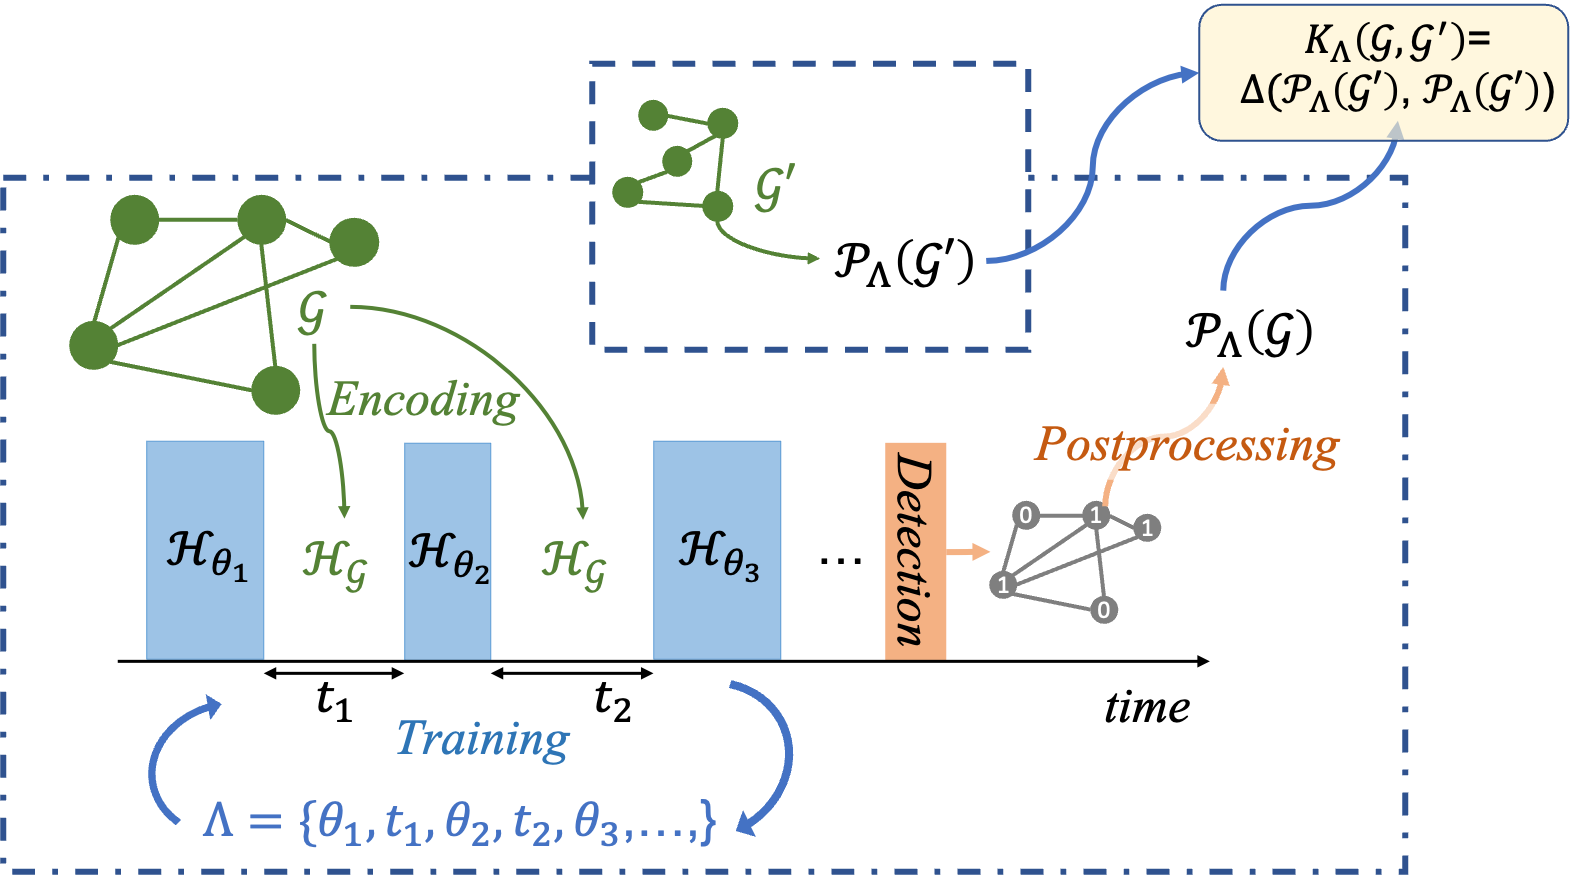
</center>

### First example

As an example, let us first implement the kernel with a scheme that allows for the computation of closed formulas.

#### Scheme

The graph Hamiltonian is here $\hat{\mathcal{H}}_\mathcal{G} = \sum_{(i,j)\in\mathcal{E}} \hat{n}_i\hat{n}_j$, an the pulse Hamiltonian is $\hat{\mathcal{H}}_1 = \sum_{i\in\mathcal{V}} \hat{\sigma}^y_i$.

The scheme is here limited to $p=1$ layer, and the two pulses are set to be Ramsey pulses of opposite parameters $\vartheta$ and $-\vartheta$, so that the final state is 
$$
\left|\psi_f(\vartheta)\right\rangle = \mathbf{\text{e}}^{{\rm i} \vartheta \hat{\mathcal{H}}_1}
                    \mathbf{\text{e}}^{-{\rm i} t\hat{\mathcal{H}}_\mathcal{G}}
                    \mathbf{\text{e}}^{-{\rm i} \vartheta \hat{\mathcal{H}}_1}\left|\psi_0\right\rangle.
$$
The total occupation $\sum_{i\in\mathcal{V}}\hat{n}_i$ is then measured in the final state and it's Fourier transform $\{p_k\}_{k\in\mathbb{N}}$ is the probability distribution extracted.

#### Total occupation
In that case, for a graph $\mathcal{G}$ containing $m_\mathcal{G}(\kappa)$ nodes of degree $\kappa$, the total occupation can be expressed explicitely as
$$
n(t)=2\,{\cos^2\vartheta\sin^2\vartheta}\sum_{\kappa\geq0} m_\mathcal{G}(\kappa) w_\kappa(t),
\hspace{1cm}
\text{with } w_\kappa(t)={\Re\left\{1-\left(\cos^2\vartheta+\mathbf{\text{e}}^{-{\rm i}  t}\sin^2\vartheta\right)^{\kappa}\right\}}.
$$


In [1]:
import numpy as np
# Load graph package
import networkx as nx

def n(G,t,theta=np.pi/4):
    '''
    Computes the expectation value of the density as a 
    function of the duration of the free evolution
    '''
    c = np.cos(theta)**2
    s = np.sin(theta)**2
    def w(kappamax,t):
        return np.array([np.real(1-(c + np.exp(-1j* t)*s)**kappa) for kappa in range(0,kappamax+1)])
    
    m = nx.degree_histogram(G)
    kappamax = len(m)-1
    return 2 * s * c * np.dot(m,w(kappamax,t))

Let us illustrate this formula on a few Erdős–Rényi graphs of $N=100$ nodes, with edge probability $\rho$ ranging from 0.2 to 0.8.

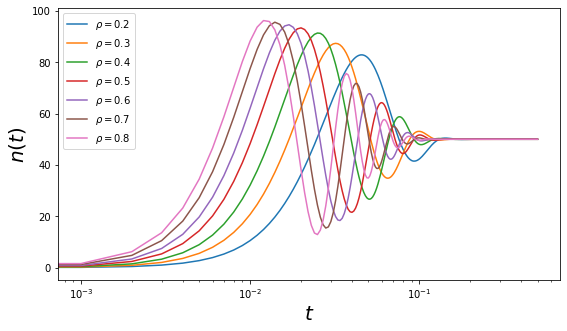

In [2]:
#Number of nodes in each graph
N=100

# edge probability for each graph
rholist = np.arange(.2,.9,.1)

# list of all graphs
graphs = []
for rho in rholist:
    G = nx.erdos_renyi_graph(N, rho)
    graphs.append(G)
    
import matplotlib.pyplot as plt
from IPython.display import Latex

tlist = np.arange(0,.5,.001)
fig, ax = plt.subplots(figsize=(9,5))
for G,rho in zip(graphs,rholist):
    ax.semilogx(tlist,[n(G,2*np.pi*t) for t in tlist],label=r'$\rho='+f'{rho:#2.1f}'+r'$')
    ax.set_xlabel('$t$', fontsize=20)
    ax.set_ylabel(r'$n(t)$', fontsize=20)
    ax.legend()

#### Fourier transform of the density
The Fourier transform of $n(t)$ (over $t\in\mathbb{R}$) can be expressed as 
$$
p_0^{(\infty)}=2\,{\cos^2\vartheta\sin^2\vartheta}\sum_{\kappa\geq0} m_\mathcal{G}(\kappa)\,(1-\cos^{2\kappa}\vartheta),\hspace{2cm}
	p_{k>0}^{(\infty)}={(\sin \vartheta)^{2(1+k)}}\sum_{\kappa\geq k} \binom{\kappa}{k}m_\mathcal{G}(\kappa)\,(\cos \vartheta)^{2(\kappa+1-k)}
$$

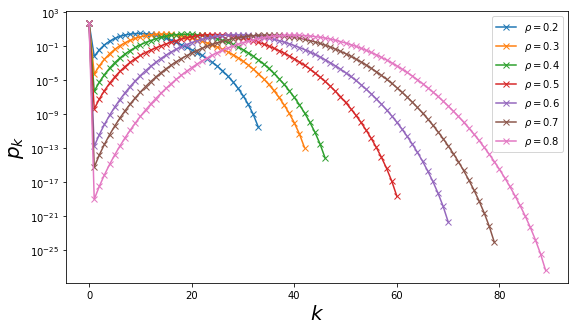

In [3]:
import scipy.special

def pk(G, theta=np.pi/4):
    cnt = nx.degree_histogram(G)
    kappamax = len(cnt)
    
    c = np.cos(theta)**2
    s = np.sin(theta)**2
    t = np.tan(theta)**2
    sp = 2 * c * s
    
    res0 = 0
    for kappa, m in enumerate(cnt):
        res0 += m * (1-c**kappa)
    res = [(sp * res0)]
    for k in range(1,kappamax):
        res0 = 0
        for kappa in range(k,kappamax):
            m = cnt[kappa]
            res0 += m * scipy.special.comb(kappa, k, exact=True) * (c**(kappa-k))
        res.append((c * (s**(k+1)) * res0))
    return res


fig, ax = plt.subplots(figsize=(9,5))
for G,rho in zip(graphs,rholist):
    ax.semilogy(pk(G),'-x',label=r'$\rho='+f'{rho:#2.1f}'+r'$')
    ax.set_xlabel('$k$', fontsize=20)
    ax.set_ylabel(r'$p_k$', fontsize=20)
    ax.legend()

#### Jensen-Shannon divergence
A distance between two probability distributions $\mathcal{P}=\{p_k\}_k$ and $\mathcal{P}'=\{p'_k\}_k$ can be constructed from the Shannon entropy $H(\mathcal{P})=-\sum_kp_k\log p_k$. It is the Jensen-Shannon divergence, defined as
$$
JS(\mathcal{P}, \mathcal{P}') = H\left(\frac{\mathcal{P}+\mathcal{P}'}{2}\right) -\frac{H(\mathcal{P})+H(\mathcal{P}')}{2}.
$$


In [4]:
def JSdiv(p1,p2):
    q1 = np.array(p1)/np.sum(p1)
    q2 = np.array(p2)/np.sum(p2)
    delta = len(q1) - len(q2)
    if delta < 0:
        q1 = np.concatenate((q1,np.array([0 for i in range(-delta)])))
    elif delta > 0:
        q2 = np.concatenate((q2,np.array([0 for i in range(delta)])))
    pq = (q1 + q2)/2
    def entropy(pl_unscaled):
        pl = np.array(pl_unscaled)/np.sum(pl_unscaled)
        res = 0
        for p in pl:
            if p>0:
                res += p*np.log(p)
        return -res
    out = entropy(pq)-(entropy(q1)+entropy(q2))/2
    return out

We now build an artificial set of graphs of two different Erdős–Rényi classes $\rho=0.35$ and $\rho=0.65$.

In [5]:
# Largest allowed graph
N_max = 100
# Size of the dataset
n_graphs = 100

# Dataset containing graphs of two different Erdős–Rényi classes
graphs = []
# Classes of these graphs
classes = []
# Probability distributions of these graphs as described above
probability_distributions = []
for _ in range(n_graphs):
    # Number of nodes in the graph in [N_max/2,N_max]
    N = np.random.randint(N_max//2,N_max+1)
    if np.random.rand() < .5:
        rho = .35
        classes.append(0)
    else:
        rho = .65
        classes.append(1)
    G = nx.erdos_renyi_graph(N, rho)
    pdist = pk(G)
    probability_distributions.append(pdist/np.sum(pdist))
    


From two graphs $\mathcal{G}$ and $\mathcal{G}'$, and their respective probability distributions $\mathcal{P}=\{p_k\}_k$ constructed from the time evolution described above, the kernel can then be expressed as
$$
K(\mathcal{G},\mathcal{G}') = \exp\left(-\mu JS(\mathcal{P}, \mathcal{P}')\right).
$$
We now build the kernel matrix containing the graph kernels between graphs in a random data set.

In [6]:
def kernel_matrix(pdist1,pdist2,mu=1):
    Kmat = np.array([[np.exp(-mu * JSdiv(p1,p2)) for p1 in pdist1] for p2 in pdist2])
    return Kmat

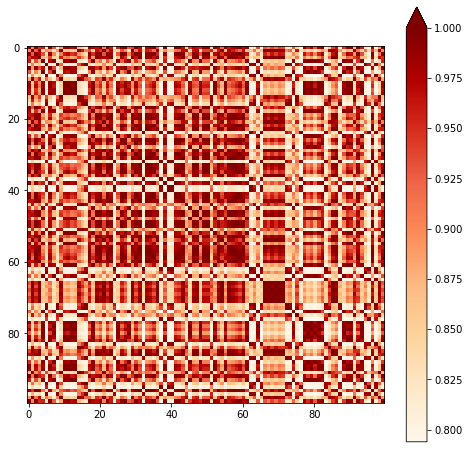

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
Kmat = kernel_matrix(probability_distributions,probability_distributions)
im = ax.imshow(Kmat,cmap='OrRd')
cbar = plt.colorbar(im,extend='max')


#### Classification : Support Vector Machine
From this kernel matrix one can build a support vector machine and use it as a prediction tool for the class of any new graph.
We use here the `sklearn` package handling the classification. More details can be found here : https://scikit-learn.org/stable/modules/svm.html#svm-mathematical-formulation.

One first train the classifier using the Kernel matrix computed above and the know classes of the corresponding graphs :

In [8]:
from sklearn import svm

classifier = svm.SVC(kernel='precomputed')
classifier.fit(Kmat, classes)

SVC(kernel='precomputed')

Given a new dataset, one first computes the kernel matrix between the new graphs and the old ones :

In [9]:
n_test = 50

# New Dataset containing graphs of two different Erdős–Rényi classes
new_graphs = []
# real Classes of these graphs
real_classes = []
# Probability distributions of these graphs as described above
new_p_dists = []
for _ in range(n_test):
    N = np.random.randint(N_max//2,N_max+1)
    if np.random.rand() < .5:
        rho = .35
        real_classes.append(0)
    else:
        rho = .65
        real_classes.append(1)
    G = nx.erdos_renyi_graph(N, rho)
    pdist = pk(G)
    new_p_dists.append(pdist/np.sum(pdist))
    
X = kernel_matrix(probability_distributions,new_p_dists)

The classes can then be predicted by the classifier :

In [10]:
predicted_classes = classifier.predict(X)

The efficiency of the Kernel can be measured via several score functions :

In [11]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score


scores_types = ['Accuracy ', 
                'f1       ', 
                'Precision', 
                'Recall   ']
scores = [f1_score(real_classes, predicted_classes, average='weighted'),
          accuracy_score(real_classes, predicted_classes),
          recall_score(real_classes, predicted_classes, average='weighted'),
          precision_score(real_classes, predicted_classes, average='weighted', zero_division=0)]

for st, s in zip(scores_types, scores):
    print(f'{st} : {s}')

Accuracy  : 0.9391677175283732
f1        : 0.94
Precision : 0.94
Recall    : 0.945625


## Application on a benchmark dataset

### Load the dataset
We now load a known benchmark dataset and apply our method to it, using Pulser and its emulator to study it on a realistic device.

In [12]:
# package allowing for easy import of the dataset
import dgl

# largest number of nodes in allowed graphs
Nmax = 12

# Loading graphs smaller than Nmax
data = dgl.data.LegacyTUDataset('Fingerprint',max_allow_node=Nmax)

print(f'Dataset contains {len(data)} graphs of at most {data.max_num_node} nodes')

Using backend: pytorch


Dataset contains 2428 graphs of at most 12 nodes


### Preprocess dataset
The dataset is preprocessed in the following way :
- First, only graphs with at leat 5 nodes are kepts
- Secondly, only classes with enough representatives are kept. Therefore, any class that contains less than 10 times fewer representatives than the largest class are disregarded

In [13]:
# Minimum number of nodes in a graph
Nmin = 5

# Number of classes in the dataset
number_of_classes = data.num_labels

# Tally the number of graphs in each class
count = np.zeros(number_of_classes,dtype='int')
for G in data:
    g, label = G
    if Nmin <= g.num_nodes():
        count[int(label)] += 1

# Number of graphs in the most represented class
size_of_largest_class = np.max(count)
# Include only classes with at least 10% of the size of the largest one
included_classes = {}       
for clas, prop in enumerate(count):
    if prop > .1*size_of_largest_class:
        included_classes[clas] = True
        
data_preprocessed = []
for G in data:
    g, label = G
    if Nmin < g.num_nodes() and int(label) in included_classes.keys():
        data_preprocessed.append(G)
        
# size of the dataset
n_graphs = len(data_preprocessed)

for clas in included_classes.keys():
    included_classes[clas] = count[clas]

print(f'After preprocessing, the dataset now contains {len(data_preprocessed)} '+
      f'graphs of at least {Nmin} and at most {Nmax} nodes, distributed '+
      f'across the different classes in the following way {included_classes}')

After preprocessing, the dataset now contains 735 graphs of at least 5 and at most 12 nodes, distributed across the different classes in the following way {0: 345, 4: 176, 5: 335, 6: 41}


In order to speed up the computations in this tutorial, we will artificialy reduce the number of classes to two, disregarding the others.

In [14]:
# We here only sample 500 graphs 
# Feel free to increase this number, 
# at the expanse of a longer computing time
dataset_targetsize = 600

kept_classes = {}
for cls in list(included_classes.keys())[0:2]:
    kept_classes[cls] = 0


data_reduced = []
test_reduced = []
for G in data_preprocessed:
    if(len(data_reduced) < dataset_targetsize):
        g, label = G
        cls = int(label)
        if cls in kept_classes.keys():
            kept_classes[cls] += 1
            data_reduced.append(G)
    elif(len(test_reduced) < secondary_dataset_size):
        g, label = G
        cls = int(label)
        if cls in kept_classes.keys():
            kept_classes[cls] += 1
            test_reduced.append(G)



# size of the dataset
n_graphs = len(data_reduced)

print(f'After preprocessing, the dataset now contains {len(data_reduced)} '+
      f'graphs of at least {Nmin} and at most {Nmax} nodes, distributed '+
      f'across {len(kept_classes)} different classes in the following way ' +
      f'{kept_classes}')

After preprocessing, the dataset now contains 443 graphs of at least 5 and at most 12 nodes, distributed across 2 different classes in the following way {0: 272, 4: 171}


### Map graphs onto machine registers
For a given graph $\mathcal{G}=(\mathcal{V},\mathcal{E})$, we first need to find a proper set of coordinates for the atoms, so that their interaction Hamiltonian encodes the topology of $\mathcal{G}$. 

Graphs as provided in the Fingerprint library are not suited to be represented on the quantum hardware.
The hardware has constraints on the maximum extent of the graph and the minimum distance between two nodes.
Moreover, the connectivity between two nodes should be related to the distance between them.
For this reason the graphs a processed using the Fruchterman-Reingold algorithm, and then rescaled in such a way as to occupy as much space as possible on the device. 
To this end, we need to find a proper register that satisfies the constraints of the device :
- Not to large (i.e. whose diameter is smaller that twice the maximal distance to the center)
- Not too dense (i.e. where no pair atoms are closer than the minimal distance between two atoms)
- Well defined bonds (i.e. each bond of the graph correspond to atoms that are within each other's Rydberg blockade radius, for a value of the amplitude $\Omega<\Omega_{max}$

In [15]:
def unpack(G):
    '''
    from a graph in the TUI dataset, generates a dictionary containing 
    the coordinates of the nodes, and a list containing all the edges
    '''
    # graph and label
    graph, label = G
    
    # convert graph to networkx object
    graph_nx = dgl.to_networkx(graph)
    
    # reshape graph using Fruchterman-Reingold algorithm, and store it as a dictionary
    graph_dict = nx.spring_layout(graph_nx, iterations=35, center=(0,0), seed=1)
    
    # edges are represented as a tuple containing the connected nodes
    node_1, node_2 = graph.edges()
    edges = list(zip(np.array(node_1), np.array(node_2)))
    
    
    # return graph dictionary and edges
    return graph_dict, edges

def max_distance(graph_dict):
    '''
    Computes the diameter of the register (i.e. the maximal distance
    between two nodes)
    '''
    return np.max(np.linalg.norm(list(graph_dict.values()), axis=1))


def min_distance(graph_dict):
    '''
    Computes the minimal distance between two nodes
    '''
    min_dist = 1.e29
    
    for i in range(len(graph_dict)):
        for j in range(i+1, len(graph_dict)):
            dr = np.linalg.norm(graph_dict[i]-graph_dict[j])
            min_dist = min(dr, min_dist)
    
    return min_dist


def max_edge_length(graph_dict, edges):
    '''
    Computes the maxiam distance between nodes connected by an edge
    of the graph
    '''
    max_length = 0
    for n1, n2 in edges:
        dr = np.linalg.norm(graph_dict[n1]-graph_dict[n2])
        max_length = max(max_length, dr)
    
    return max_length
        
    
def upscale_graph(graph_dict, edges, device):
    '''
    Stretch the graph as much as possible so as to increase the
    ratio between Omega and the couplings
    '''
    scale_max = device.max_radial_distance/max_distance(graph_dict)
    for node in graph_dict:
        graph_dict[node] *= .95*scale_max

In [16]:
from pulser import Register
from pulser.devices import Chadoq2

device = Chadoq2
r_max = device.max_radial_distance
d_min = device.min_atom_distance

omega_max = device.channels['rydberg_global'].max_amp
min_bond_length = device.rabi_from_blockade(omega_max)

def reg_from_graph(g):
    
    
    reg = Register.from_coordinates(coords)
    
    return reg

In [17]:
# The list of registers for each graph
reg_list = []

# The list of Rabi frequencies setting the Rydberg
# blockade radius to the maximal edge distance of each graph
rabi_list = []

# List of list of edges
edges_list = []

# List of class of each graph
label_list = []
for G in data_reduced:
    g, label = G   
    
    label_list.append(int(label))
    
    graph_dict, edges = unpack(G)
    
    edges_list.append(edges)

    # Rescale the graph to satisfy device constraints
    upscale_graph(graph_dict, edges, device)

    # Find the blockade radius and corresponding Rabi frequency
    blockade_radius = max_edge_length(graph_dict, edges)
    rabi = Chadoq2.rabi_from_blockade(blockade_radius)
    rabi_list.append(rabi)
    
    # Create the register
    reg = Register(graph_dict)
    reg_list.append(reg)

### Optimized preparation of the equal superposition of Ising states
In order to reduce the number of parameters to train in this tutorial, we first determine the optimal constant detuning pulse that prepares the system in an equal superposition of all Ising states $\left|\psi_s\right\rangle = \bigotimes_{i\in\mathcal{V}} \frac{1}{\sqrt{2}}\left(\left|0\right\rangle+\left|1\right\rangle\right)$.

In the absence of interactions, this obtained from the empty state via a Ramsey pulse with Hamiltonian $\hat{\mathcal{H}}_1 = \frac{\Omega}{2}\sum_{i\in\mathcal{V}} \hat{\sigma}^y_i$ for a duration $t= \pi/(2\Omega)$. 

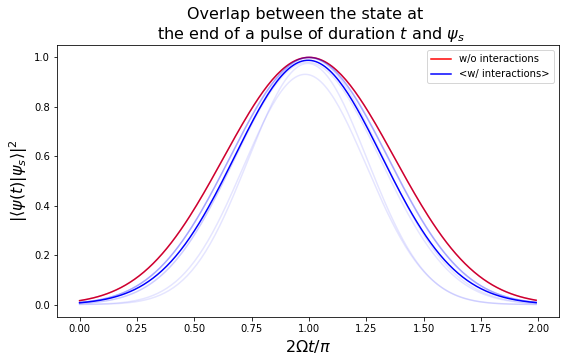

In [18]:
from qutip import *
from pulser import Pulse, Sequence, Simulation

### First compute the overlap as a function of time in the ideal case

#Number of vertices
Nv = 6

# empty state
psi0 = tensor( [fock(2,1) for i in range(Nv)])

# equal superposition state of Nv qubits
def equal_sup(Nv):
    return tensor( [(fock(2,1)+fock(2,0))/np.sqrt(2) for i in range(Nv)])

# sigma^y operators
Sigma_y = [ tensor([sigmay() if i == j else qeye(2) for i in range(Nv)] ) for j in range(Nv)]

# Pulse Hamiltonian
H_1 = 0
for Sy in Sigma_y:
    H_1 += -.5*omega_max*Sy
    
# Pulse duration set to twice the peak location
pulse_duration = np.pi/omega_max
# Times at which the overlap is measured
tlist = np.arange(0,pulse_duration,.001)
# Equal superposition of all Ising states
psi_s = equal_sup(Nv)

# Solution of the Schrödinger equation at each time in tlist 
simulation_results = sesolve(H_1, psi0, tlist)

# Overlap with the target state psi_s
overlaps_ideal = [np.abs(s.overlap(psi_s))**2 for s in simulation_results.states]

### Then compute the overlap as a function of time for a few graphs in the dataset
n_samples = 10
overlaps_data = []
for i in range(n_samples):
    n0 = np.random.randint(len(data_reduced))
    reg = reg_list[n0]
    
    seq = Sequence(reg, device)
    seq.declare_channel('Ising','rydberg_global')
    
    # be careful about the units : Omega(rad/μs) -> t (ns)
    p = Pulse.ConstantPulse(1000*np.pi/omega_max,
                            amplitude=omega_max,
                            detuning=0, phase=np.pi/2)
    seq.add(p, 'Ising')

    simul = Simulation(seq)
    results = simul.run()

    Nv = len(reg.qubits)
    psi_s = equal_sup(Nv)

    ov = [np.abs(s.overlap(psi_s))**2 for s in results.states]
    overlaps_data.append(ov)
# Compute the average trace of the overlap
overlaps_mean = [np.mean([ov[i] for ov in overlaps_data]) for i,s in enumerate(simul._times) ]
    
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(simulation_results.times/(.5*np.pi/omega_max),overlaps_ideal,label='w/o interactions', color='red')
ax.plot(simul._times/(.5*np.pi/omega_max),overlaps_mean,label='<w/ interactions>',color='blue')
for ov in overlaps_data:
    ax.plot(simul._times/(.5*np.pi/omega_max),ov, color='blue', alpha=0.1)
ax.set_title('Overlap between the state at \n the end of a pulse of duration $t$ and $\psi_s$',fontsize=16)
ax.set_xlabel(r'$2\Omega t/\pi$',fontsize=16)
ax.set_ylabel(r'$|\left\langle \psi(t)|\psi_s\right\rangle|^2$',fontsize=16)
ax.legend()

plt.show()

As illustrated above, withtout interaction (red curve) the overlaps reaches a maximum of 1 at $t= \pi/(2\Omega)$. 
In the presence of interactions (faint line), the maximal overlap is reached at the same time for all graphs, but the value of this overlap is slightly reduced, and the peak is narrower for most graphs. The solid line represents the average of the overlap over all sampled graphs.

### Single parameter Pulse
Let us now implement the Quantum Evolution Kernel on Pulser.
As an illustration will here consider two layers, so that the final state is
$$
\left|\psi_f(\vartheta)\right\rangle = \mathbf{\text{e}}^{{\rm i} \hat{\mathcal{H}}_1 t_2}
                    \mathbf{\text{e}}^{-{\rm i} \tau_1\hat{\mathcal{H}}_\mathcal{G}}\mathbf{\text{e}}^{-{\rm i} \hat{\mathcal{H}}_1 t_1}
                    \mathbf{\text{e}}^{-{\rm i} \tau_0\hat{\mathcal{H}}_\mathcal{G}}
                    \mathbf{\text{e}}^{-{\rm i} \hat{\mathcal{H}}_1 t_0}\left|\psi_0\right\rangle,
$$
where $\hat{\mathcal{H}}_\mathcal{G} = \sum_{(i,j)\in\mathcal{E}} (C_6 /r_{ij}^{6})\hat{n}_i\hat{n}_j$ and $\hat{\mathcal{H}}_1(\Omega) = \frac{\Omega}{2}\sum_{i\in\mathcal{V}} \hat{\sigma}^y_i$.

In practise, $\hat{\mathcal{H}}_\mathcal{G}$ is never turned of, so that the *true* pulse Hamiltonian is $\hat{\mathcal{H}}_1(\Omega)+\hat{\mathcal{H}}_\mathcal{G}$.
Furthermore, in order to explicitely distinguish edges from other pairs of atom, we include a finite amplitude $\Omega_g$ during the graph Hamiltonian evolution, so that the effective graph Hamiltonian is $\hat{\mathcal{H}}_1(\Omega_g)+\hat{\mathcal{H}}_\mathcal{G}$

At the end of the pulse the Ising energy $\hat{\mathcal{O}}=\sum_{(i,j)\in\mathcal{E}}\hat{n}_i\hat{n}_j$ is measured.

For the sake of brievety, we here set $t_0 = t_2 = t = \pi/(2\Omega)$, where $\Omega$ is set to the highgest possible value compatible with the device (in particular so that $t\geq 16$ ns), $\tau_0 = \tau_1 = \tau$ and set the total time $T = t_0+\tau_0+t_1+\tau_1+t_2$ to a constant (for instance $T = 512$ ns). This way, only $t_1$ needs to be optimized.

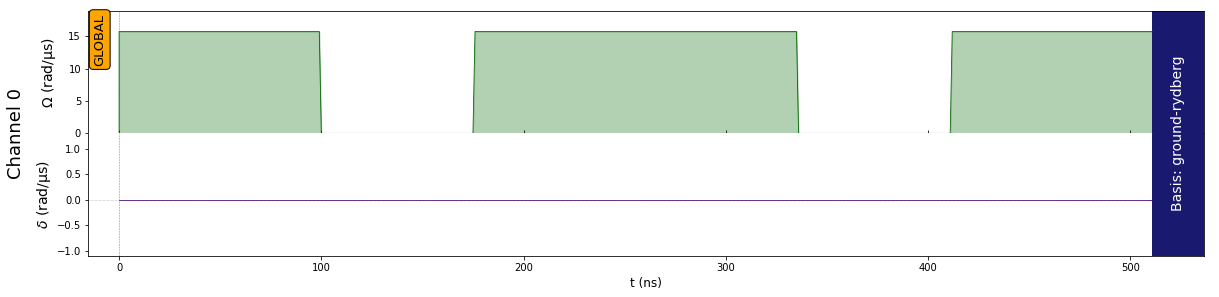

In [19]:
def pulse_seqence(reg, 
                  t_1=100, 
                  omega=omega_max, # amplitude of the initial and final pulses
                  omega_g=0, # amplitude in the "free evolution" parts
                  total_time=512): # total duration of the pulse
    seq = Sequence(reg, device)
    seq.declare_channel('Channel 0','rydberg_global')
    
    # making sure that the value of omega does not exceed the maximal value,
    # and that it doesn't lead to a pulse duration that is too short
    omega = min([omega,1000*np.pi/2,omega_max])
    
    # Set the initial and final pulse times to the optimal value    
    # be careful about the units : Omega(rad/μs) -> t (ns)
    t = 1000*np.pi/(2*omega)
    # Set the total_time
    tau = (total_time - 2*t - t_1)/2
    
    initial_pulse = Pulse.ConstantPulse(t,omega, 0, phase=np.pi/2)
    if total_time > t_1 + 2*t:
        Hg_pulse = Pulse.ConstantPulse(tau,omega_g, 0, phase=np.pi/2)
    if t_1 > 0:
        middle_pulse = Pulse.ConstantPulse(t_1,omega, 0, phase=np.pi/2)
    final_pulse = Pulse.ConstantPulse(t,omega, 0, phase=np.pi/2)
    
    seq.add(initial_pulse, 'Channel 0')
    if total_time > t_1 + 2*t:
        seq.add(Hg_pulse, 'Channel 0')
    if t_1 > 0:
        seq.add(middle_pulse, 'Channel 0')
    if total_time > t_1 + 2*t:
        seq.add(Hg_pulse, 'Channel 0')
    seq.add(final_pulse, 'Channel 0')
    
    seq.measure(basis='ground-rydberg')
    
    return seq
    
# Illustrate the pulse on a register containing a single atom
reg = Register.from_coordinates([(0,0)])
pulse_seqence(reg, t_1=160).draw()

## Computing the probability distribution

In [20]:
def proba_distributions(t_1 = 100, #duration of the central pulse
                        omega = omega_max, # amplitude of the pulses
                        omega_g_factor = 1, # set to 1 if the Amplitude is non zero during the "free evolution"
                        total_time = 512,  # total duration of the pulse
                        Nsamples = 1000,
                        indices = list(range(n_graphs))): #indices of the graphs used
    
    bins=np.linspace(0, Nmax*Nmax, Nmax*Nmax+1)
    histograms = []
    for i in indices:
        reg, rabi, edges = reg_list[i], rabi_list[i], edges_list[i]
        seq = pulse_seqence(reg, 
                            t_1=t_1, 
                            omega=omega, 
                            omega_g=omega_g_factor*rabi, 
                            total_time=total_time)
        
        # Simulate and sample
        simul = Simulation(seq,evaluation_times="Full")
        results = simul.run()
        sampling = results.sample_final_state(N_samples=Nsamples)
        
        # Create a list with the measurements of the ising energy
        ie_meas = []
        ie_weights = []
        for bitstring,num in sampling.items():
            ie_meas.append(compute_ising_energy(bitstring, edges))
            ie_weights.append(num)
            
        # Create histogram of the measurements and append to list
        ncount, b = np.histogram(ie_meas, bins=bins, density=True, weights=ie_weights)
        histograms.append(ncount)
    return histograms
        


def compute_ising_energy(outcome, edges):
    
    # split outcome string in a list
    outcome_ls = [char for char in outcome]
    
    energy = 0
    
    for edge in edges:
        i = int(edge[0])
        j = int(edge[1])
        if i < j:
            energy += int(outcome_ls[i])*int(outcome_ls[j])
    
    return energy

Let us first ignore the middle pulse and set $t_1=0$. 

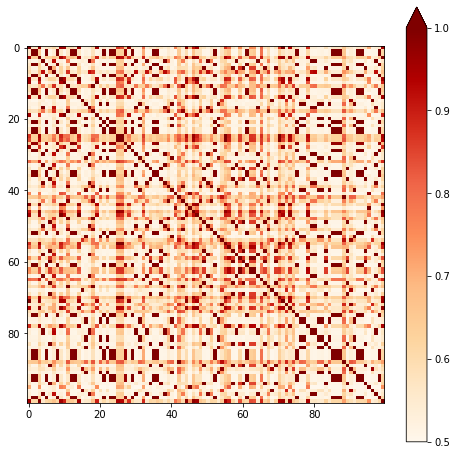

In [21]:
import random

#sample 150 graphs and train on 100 of them
n_train = 100
n_test = 50

# randomize graph order
indices_all = list(range(n_graphs))
indices_train = indices_all[0:n_train]
indices_test = indices_all[n_train:n_train+n_test]

# Labels of the sampled graphs
train_classes = [label_list[i] for i in indices_train]
test_classes = [label_list[i] for i in indices_test]


# Probability distributions obtained after the pulse
probas_train = proba_distributions(t_1 = 0, 
                                   indices = indices_train)

# Resulting kernel matrix
Kmat = kernel_matrix(probas_train,probas_train)

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(Kmat,cmap='OrRd')
cbar = plt.colorbar(im,extend='max')


In [22]:
# Apply SVM on this training set
classifier = svm.SVC(kernel='precomputed')
classifier.fit(Kmat, train_classes)

# Compute probability distributions on test set
probas_test = proba_distributions(t_1 = 0, 
                                   indices = indices_test)

In [23]:
# Compute the kernel matrix between the training and test sets
X = kernel_matrix(probas_train,probas_test)

# Predict the classes of the test graphs
predicted_classes = classifier.predict(X)

#Compute the resulting scores
scores = [f1_score(test_classes, predicted_classes, average='weighted'),
          accuracy_score(test_classes, predicted_classes),
          recall_score(test_classes, predicted_classes, average='weighted'),
          precision_score(test_classes, predicted_classes, average='weighted', zero_division=0)]

for st, s in zip(scores_types, scores):
    print(f'{st} : {s}')

Accuracy  : 0.7327498927498928
f1        : 0.74
Precision : 0.74
Recall    : 0.7414705882352942


## Optimization of the pulse sequence
We now proceed to the optimization of the pulse sequence. To this end, we evaluate the score of the classification (here, its accuracy) for various durations of the central pulse and chose the best one.
For a fixed duration $t_1$ of the central pulse, the procedure goes as follows:

1) The data is divided randomly in N blocks.

2) Use N-1 blocks to train the SVM, and the last block to test the predictions.

3) Repeat the procedure M times and average the score.

At this point, select the optimal duration of the middle pulse by performing a greedy search among the allowed values.

In [24]:
import time

N = 4
M = 1

def score_function(t_1=100, 
                   total_time=512, 
                   repetitions=M, 
                   nblocks=N,
                   indices = list(range(n_graphs))): # list of graphs included
    '''
    Computes the accuracy, f1, precision and recall
    '''
    
    accuracy = []
    f1 = []
    precision = []
    recall = []
    
    n_g = len(indices)
    
    block_size = n_g//nblocks
    
    print(f'Using {nblocks} blocks containing {block_size} graphs each')
    
    for r in range(repetitions):
        print(f'Starting split #{r+1} of {repetitions}')
        
        #divide data in training set and test set
        indices_all = np.array([i for i in indices])
        np.random.shuffle(indices_all)
        
        scores = np.zeros((4,))
        for iblock in range(nblocks):
            start_time = time.time()
            print(f'    Using block #{iblock+1} of {nblocks} as a test set')
            indices_test = [indices_all[(iblock*block_size+i)%n_g] for i in range(block_size)]
            indices_train =[indices_all[((iblock+1)*block_size+i)%n_g] for i in range(n_g-block_size)]

            y_train = np.array([label_list[i] for i in indices_train])
            y_test = np.array([label_list[i] for i in indices_test])


            # create probability histogram for train and test data 
            histo_train = proba_distributions(t_1 = t_1, 
                                              total_time = total_time, 
                                              Nsamples = 1000,
                                              indices = indices_train)
            histo_test = proba_distributions(t_1 = t_1, 
                                             total_time = total_time, 
                                             Nsamples = 1000,
                                             indices = indices_test)

            # create kernel matrix
            X_train = kernel_matrix(histo_train, histo_train)
            X_test = kernel_matrix(histo_train, histo_test)

            # train svm
            clf = svm.SVC(kernel='precomputed')
            clf.fit(X_train, y_train)

            # get prediction on test data
            y_predict = clf.predict(X_test)
            
            scores[0] += accuracy_score(y_test, y_predict)
            scores[1] += f1_score(y_test, y_predict, average='weighted')
            scores[2] += precision_score(y_test, y_predict, average='weighted', zero_division=0)
            scores[3] += recall_score(y_test, y_predict, average='weighted')
            print(f'        After {time.time() - start_time:4.1f} seconds, the average scores are :')
            for st,s in zip(scores_types,scores):
                print(f'            {st} : {s/(1+iblock):6.3f}')
    
        # calculate score metrics
        accuracy.append(scores[0]/nblocks)
        f1.append(scores[1]/nblocks)
        precision.append(scores[2]/nblocks)
        recall.append(scores[3]/nblocks)
        
        A = (np.mean(accuracy), np.std(accuracy))
        B = (np.mean(f1), np.std(f1))
        C = (np.mean(precision), np.std(precision))
        D = (np.mean(recall), np.std(recall))
    
    return A, B, C, D

We now look for the best pulse by varying the duration of the middle pulse. The total time is limited to a small value, and the data set is reduced to $n_g=100$ graphs for the sake of time in this tutorial.

Furthermore, the score is evaluated only on $M=2$ random splits, with a $N=4$-fold cross validation.

For more accurate estimates, those numbers can be increased.

In [ ]:
#%%time

omega = min([1000*np.pi/2,omega_max])
t_g = 4*round(1000*np.pi/(4*2*omega))

total_time = 2*t_g + 128

# duration of the middle pulse
durations = range(0, total_time-2*round(t_g)-32,32)


M = 2
N = 4

n_g = 100
indices_all = list(range(n_graphs))
indices_in = indices_all[0:n_g]

scores_2layers = {}

for s in scores_types:
    scores_2layers[s] = []
    
print(f'  ------------------------------------------')
print(f'||   Maximal of the middle pulse: {durations[-1]:4d} ns   ||')
print(f'  ------------------------------------------')
    
for t_1 in durations:
    print(f' -------------------------------------------')
    print(f'|   Duration of the middle pulse: {t_1:4d} ns   |')
    print(f'|   Total duration of the pulse:  {total_time:4d} ns   |')
    print(f' -------------------------------------------')
    score_inst = score_function(t_1=t_1, 
                                total_time=total_time, 
                                repetitions=M, 
                                nblocks=N,
                                indices=indices_in)
    
    for sc,st in zip(score_inst,scores_types):
        scores_2layers[st].append(sc)
        print(f'> {st}: {sc[0]:6.3} +/- {sc[1]:6.3}')
    print()

  ------------------------------------------
||   Maximal of the middle pulse:   64 ns   ||
  ------------------------------------------
 -------------------------------------------
|   Duration of the middle pulse:    0 ns   |
|   Total duration of the pulse:   328 ns   |
 -------------------------------------------
Using 4 blocks containing 25 graphs each
Starting split #1 of 2
    Using block #1 of 4 as a test set
        After 26.5 seconds, the scores are :
            Accuracy  :  0.720
            f1        :  0.708
            Precision :  0.719
            Recall    :  0.720
    Using block #2 of 4 as a test set
        After 26.8 seconds, the scores are :
            Accuracy  :  0.760
            f1        :  0.752
            Precision :  0.757
            Recall    :  0.760
    Using block #3 of 4 as a test set
        After 27.3 seconds, the scores are :
            Accuracy  :  0.760
            f1        :  0.751
            Precision :  0.755
            Recall    :  0.

The optimal value of the duration of the middle pulse can be estimated by this scan of it values :

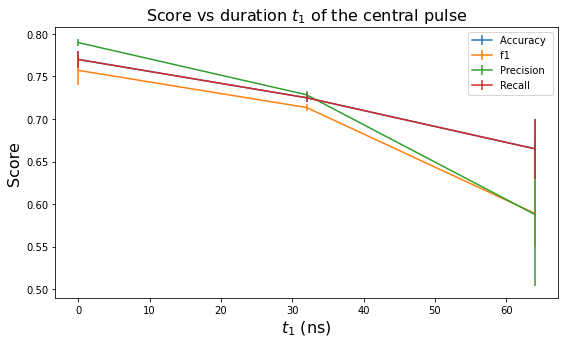

In [26]:
fig, ax = plt.subplots(figsize=(9,5))
for k in scores_2layers.keys():
    ax.errorbar(list(durations),[s[0] for s in scores_2layers[k]],  yerr=[s[1] for s in scores_2layers[k]],label=k)
ax.set_title('Score vs duration $t_1$ of the central pulse',fontsize=16)
ax.set_ylabel(r'Score',fontsize=16)
ax.set_xlabel(r'$t_1$ (ns)',fontsize=16)
ax.legend()

plt.show()